In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import manifold
from scipy.spatial import distance
from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
from rdkit.Chem import Draw
from rdkit.Chem.SaltRemover import SaltRemover

# Load drugbank and calculate fingerprints

In [2]:
supp = Chem.SDMolSupplier("../data/drugbank.sdf")
drugbank = [m for m in supp if m]
fps = [Chem.GetMorganFingerprintAsBitVect(m,2,nBits=1024) for m in drugbank]

# Prepare full distance matrix

In [3]:
sparse_mat = distance.pdist(fps,metric="jaccard")
dist_mat = distance.squareform(sparse_mat)

# Calculate new 2D coordinates with MDS

In [4]:
#----------------------------------------------------------------------
# MDS  embedding of the digits dataset
clf = manifold.MDS(n_components=2, n_init=1, max_iter=100, dissimilarity="precomputed")
X_mds = clf.fit_transform(dist_mat)

# Function visualizing 2D points

In [5]:
#----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None, highlights=[]):
    fig = plt.figure()
    # ax = plt.subplot(111)
    for i, point in enumerate(X):
        x,y = point
        if i in highlights:
            plt.plot([x],[y],"r.", markersize=4)
        else:
            plt.plot([x],[y],"k.", markersize=1)
    # plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
    return fig

# Show drugbank in 2D space

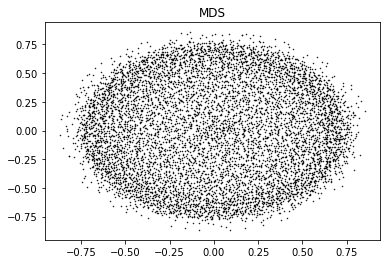

In [6]:
plot_embedding(X_mds,"MDS")

# Substructures with acetylsalicylic acid

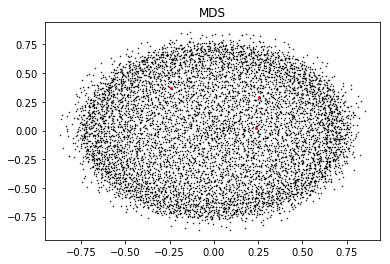

In [7]:
acet_salicyl_a = Chem.MolFromSmiles("O=C(C)Oc1ccccc1C(=O)O")
acet_salicyl_a_idxs = [i for i,m in enumerate(drugbank) if m.HasSubstructMatch(acet_salicyl_a)]
plot_embedding(X_mds,"MDS",highlights=acet_salicyl_a_idxs)

# Structures similar to our structure

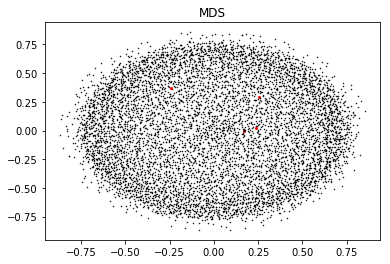

In [8]:
aspirine_like_structs_idxs = [i for i, dist in enumerate(dist_mat[824,]) if dist<0.5] 
plot_embedding(X_mds,"MDS",highlights=aspirine_like_structs_idxs)

# Picking of diverse set

In [9]:
# This implementation is also working but why calculate distance if we already have it
# def distance_function(index1, index2, *args, fingerprints=fps):
#     return 1 - DataStructs.FingerprintSimilarity(fingerprints[index1],fingerprints[index2])

def full_distance_function(index1, index2, *args, matrix=dist_mat):
    return dist_mat[index1,index2]

picker = MaxMinPicker()
picked = picker.LazyPick(full_distance_function, len(fps), 100, seed=666)
highlighted = tuple(picked)

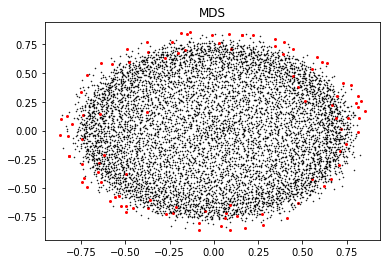

In [10]:
plot_embedding(X_mds,"MDS",highlights=highlighted)

# What have we picked?

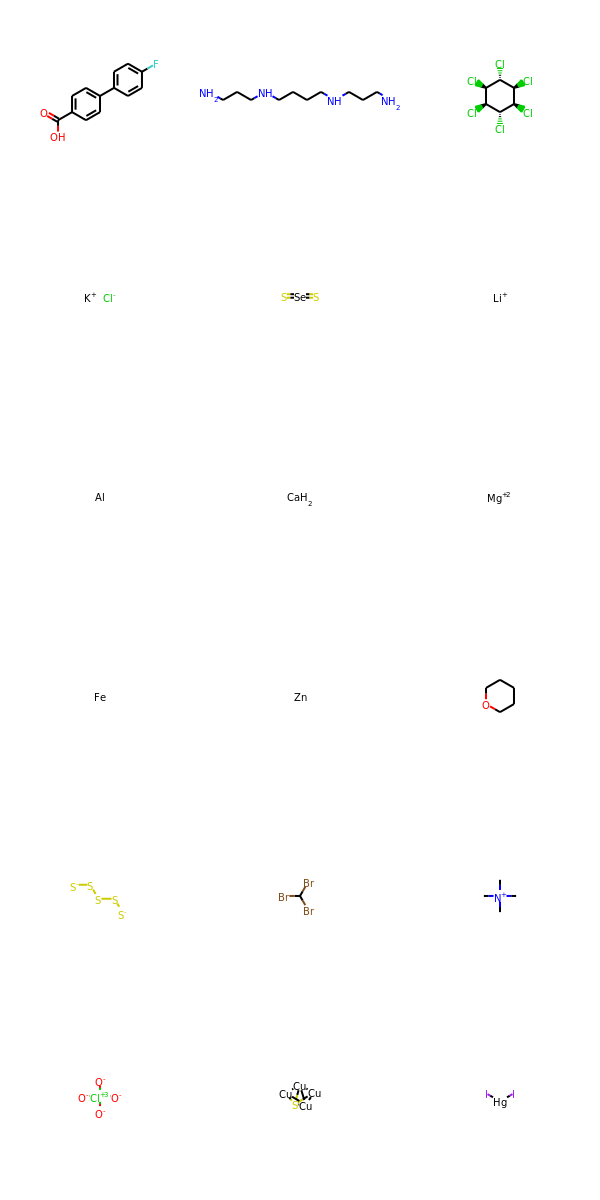

In [11]:
Draw.MolsToGridImage([drugbank[i] for i in picked[:18]])

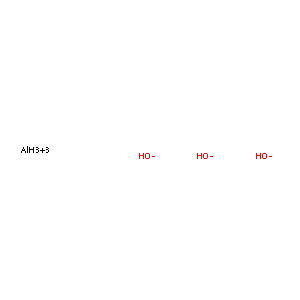

In [12]:
# This one makes all structures so tiny that you can't see them in grid (there could be even more problematic onessimilar)
Draw.MolToImage(drugbank[picked[18]])

# Too much inorganic will kill you
Usually in chemiformatics, only organic structures are used, so we have to deal with inorganic ones.
Let's start with structures without carbon atom

In [13]:
hasCarbonPatt = Chem.MolFromSmarts("[#6]")
hasCarbons = [(i, m.HasSubstructMatch(hasCarbonPatt)) for i,m in enumerate(drugbank)]
hasCarbonIdxs = [i for i,has in hasCarbons if has]
hasNotCarbonIdxs = [i for i,has in hasCarbons if not has]
len(hasCarbonIdxs)

7031

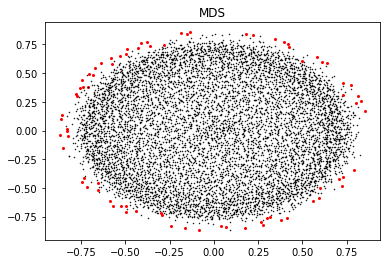

In [14]:
plot_embedding(X_mds,"MDS",highlights=hasNotCarbonIdxs)

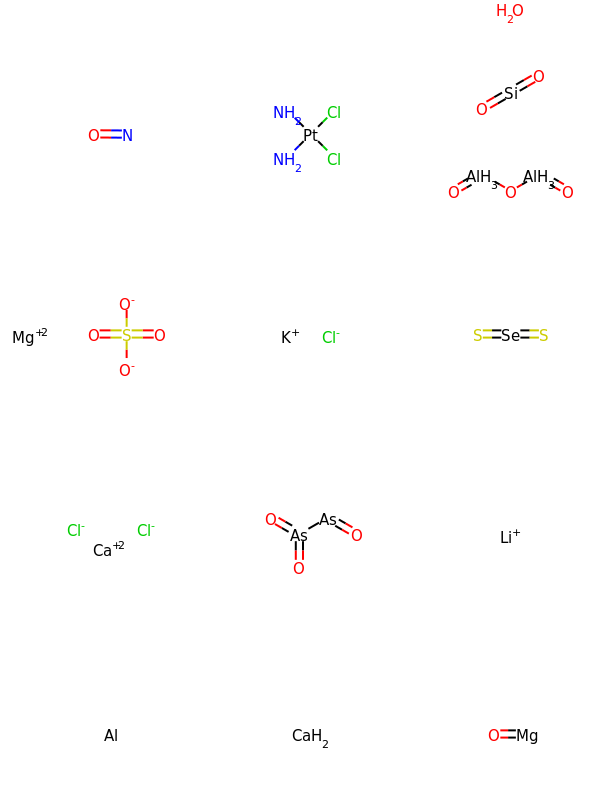

In [15]:
Draw.MolsToGridImage([drugbank[i] for i in hasNotCarbonIdxs[:12]])

We want definitely to remove such inorganic structures, but is it enough?

# Remove inorganic structure

Let's remove structures without carbon and with uncommon atom type (not in organic subset)

In [16]:
onlyOrganicPatt = Chem.MolFromSmarts("[!#6;!#7;!#8;!#16;!F;!Cl;!Br;!I]")
onlyOrganics = [(i, m.HasSubstructMatch(hasCarbonPatt) and not m.HasSubstructMatch(onlyOrganicPatt)) for i,m in enumerate(drugbank)]
onlyOrganicIdxs = [i for i,hasPatt in onlyOrganics if hasPatt]
notOnlyOrganicIdxs = [i for i,hasPatt in onlyOrganics if not hasPatt]

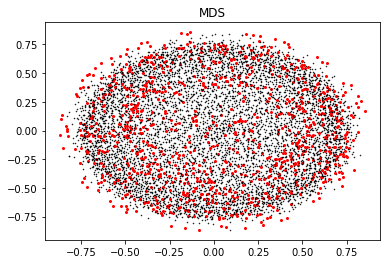

In [17]:
plot_embedding(X_mds,"MDS",highlights=notOnlyOrganicIdxs)

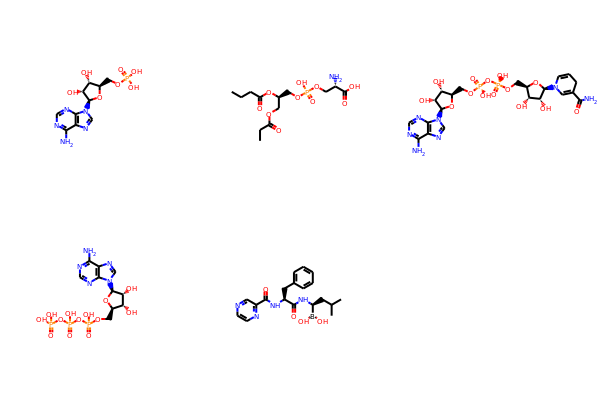

In [18]:
Draw.MolsToGridImage([drugbank[i] for i in notOnlyOrganicIdxs[2:7]])
# Structures at notOnlyOrganicIdxs[1 and 7] are not able to pass sanity check (that's why I skipped them)

In [19]:
# These structures are not sanitizable (we can't easily depict it), you should consider usefullness of such structures
print(Chem.MolToSmiles(drugbank[notOnlyOrganicIdxs[1]]))
notSanitizable = drugbank[notOnlyOrganicIdxs[1]]
Chem.SanitizeMol(notSanitizable)

CC1=C2N3=C(C=C4N5=C(C(C)=C6N7C8C(CC(N)=O)C6(C)CCC(=O)NCC(C)OP(=O)(O)OC6C(CO)OC(C6O)n6cn(c9cc(C)c(C)cc96)~[Co]7~5~3(C#N)~N3=C1C(CCC(N)=O)C(C)(CC(N)=O)C83C)C(CCC(N)=O)C4(C)C)C(CCC(N)=O)C2(C)CC(N)=O


ValueError: Sanitization error: Can't kekulize mol.  Unkekulized atoms: 65 66 67 68 69 72 74


In [ ]:
lou událost vyšetřují, se nyní obracejí k veřejnosti s žádostí o pomoc při zjištění totožnosti napadeného. Uvedli, že z místa odešel jiným směrem než agresor a jeho # but after sanitization (even it failed), everything is awesome
Draw.MolToImage(notSanitizable)

Do we really want to remove such structures?

In [ ]:
Draw.MolToImage(drugbank[notOnlyOrganicIdxs[13]])

Or are we too far and we just want to remove inorganic part?
How could be this improved:

Salt remover
http://www.rdkit.org/Python_Docs/rdkit.Chem.SaltRemover.SaltRemover-class.html

Neutralizing
http://www.rdkit.org/docs/Cookbook.html#neutralizing-charged-molecules

# Remove salts, neutralize, and maybe even standardize

In [ ]:
remover = SaltRemover(defnData='[!C;!c;!#7;!#8;!#16;!Cl;!F;!Br;!I]')
remover2 = SaltRemover()

In [ ]:
print([Chem.MolToSmarts(mol) for mol in remover.salts])
print([Chem.MolToSmarts(mol) for mol in remover2.salts])

Default patterns seem to be good

In [ ]:
print(Chem.MolToSmiles(drugbank[notOnlyOrganicIdxs[13]]))
print(Chem.MolToSmiles(remover2(drugbank[notOnlyOrganicIdxs[13]])))

# In this case, we ommit the issue with fragmented structures as we use fingerprint and both fragments are same

We removed cation but then we should neutralize structure (it cannot work absolutely, for example quaternary ammonium cations)

In [ ]:
""" contribution from Hans de Winter """
def _InitialiseNeutralisationReactions():
    patts= (
        # Imidazoles
        ('[n+;H]','n'),
        # Amines
        ('[N+;!H0]','N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]','O'),
        # Thiols
        ('[S-;X1]','S'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]','N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]','N'),
        # Tetrazoles
        ('[n-]','[nH]'),
        # Sulfoxides
        ('[$([S-]=O)]','S'),
        # Amides
        ('[$([N-]C=O)]','N'),
        )
    return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

_reactions=None
def NeutraliseCharges(mol, reactions=None):
    global _reactions
    if reactions is None:
        if _reactions is None:
            _reactions=_InitialiseNeutralisationReactions()
        reactions=_reactions
    replaced = False
    for i,(reactant, product) in enumerate(reactions):
        while mol.HasSubstructMatch(reactant):
            replaced = True
            rms = Chem.ReplaceSubstructs(mol, reactant, product)
            mol = rms[0]
    return mol

In [ ]:
print(Chem.MolToSmiles(remover2(drugbank[notOnlyOrganicIdxs[13]])))
print(Chem.MolToSmiles(NeutraliseCharges(remover2(drugbank[notOnlyOrganicIdxs[13]]))))

Our finale standardization function could be implemented as:

In [ ]:
_saltRemover = SaltRemover()
_inorganicPatt = Chem.MolFromSmarts("[!#6;!#7;!#8;!#16;!F;!Cl;!Br;!I]")
_carbonPatt = Chem.MolFromSmarts("[#6]")
def standardize(mol):
    if mol.HasSubstructMatch(_carbonPatt):
        mol = _saltRemover(mol)
        if mol.GetNumAtoms()==0:
            return None
        else:
            mol = NeutraliseCharges(mol)
            if mol.HasSubstructMatch(_inorganicPatt):
                return None
            else:
                # Sanitize mol, without sanitization some structures can't be drawn or fingerprinted
                Chem.SanitizeMol(mol) # add catch block?
                return mol
    else:
        return None

# Let's make our visualization great (again)
remove salts, neutralize and then remove the rest of inogranics

In [ ]:
supp = Chem.SDMolSupplier("../data/drugbank.sdf")
cleanDrugbank = [sm for sm in (standardize(m) for m in supp if m) if sm]
cleanFps = [Chem.GetMorganFingerprintAsBitVect(m,2,nBits=1024) for i,m in enumerate(cleanDrugbank)]

In [ ]:
#Prepare full distance matrix

clean_sparse_mat = distance.pdist(cleanFps,metric="jaccard")
clean_dist_mat = distance.squareform(clean_sparse_mat)

#Calculate new 2D coordinates with MDS

#----------------------------------------------------------------------
# MDS  embedding of the digits dataset
clf = manifold.MDS(n_components=2, n_init=1, max_iter=100, dissimilarity="precomputed")
clean_mds = clf.fit_transform(clean_dist_mat)

In [ ]:
def clean_distance_function(index1, index2, *args, matrix=clean_dist_mat):
    return matrix[index1,index2]

picker = MaxMinPicker()
clean_picked = picker.LazyPick(clean_distance_function, len(cleanFps), 100, seed=666)
clean_highlighted = tuple(clean_picked)

In [ ]:
plot_embedding(clean_mds,"MDS",highlights=clean_highlighted)


In [ ]:
Draw.MolsToGridImage([cleanDrugbank[i] for i in clean_picked[:12]])

In [ ]:
# Calcium Cyanamide CaCN2
print(Chem.MolToSmiles(cleanDrugbank[clean_picked[3]]))
Draw.MolToImage(cleanDrugbank[clean_picked[3]])

# We can try some advanced methods

http://molvs.readthedocs.io/en/latest/index.html

https://github.com/flatkinson/standardiser